<a href="https://colab.research.google.com/github/ben-wycliff/dl_final_project/blob/main/nb2_with_dataaugmentation_and_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip dataset from google drive
!unzip /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/known_images.zip

# Imports

In [72]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay,
                             classification_report)

import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import (img_to_array, load_img)

# Constants

In [65]:
BATCH_SIZE = 32,
INPUT_SIZE = (391, 488)

# Prepare Dataset

In [11]:
# create dataframe
images = os.listdir("./known_images")
labels = ["0" if "normal" in i  else "1" for i in images]
df = pd.DataFrame({
    "images": images,
    "labels": labels
})
df.to_csv("dataset.csv")
df.head(10) # all sick images are labelled 1 while normal images are labelled 2

,images,labels
0,sick_272.png,1
1,sick_292.png,1
2,sick_144.png,1
3,sick_50.png,1
4,normal_95.png,0
5,sick_92.png,1
6,normal_210.png,0
7,normal_253.png,0
8,sick_12.png,1
9,normal_71.png,0


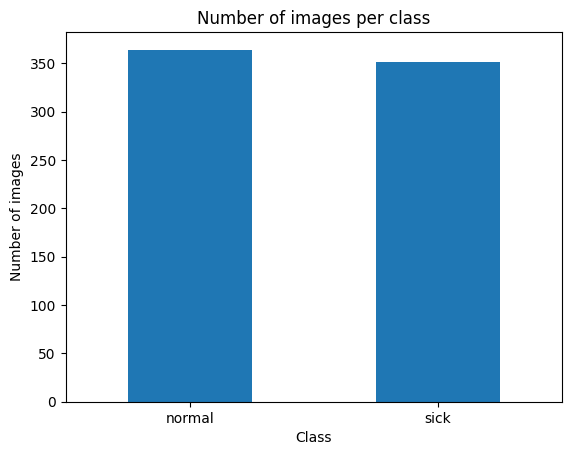

In [12]:
# From this plot we see the number of images is fairly
# distributed between the two classes
df.labels.value_counts().plot(kind="bar"); 
plt.title("Number of images per class")
plt.xticks(ticks=[0,1],labels=["normal", "sick"], rotation=0)
plt.ylabel("Number of images")
plt.xlabel("Class")
plt.show()

In [20]:
df = pd.read_csv("/content/drive/MyDrive/Personal/Computer Vision/dl_final_project/dataset.csv")
df["labels"] = df["labels"].astype(str)

In [21]:
# create dataset splits
df_train, df_eval = train_test_split(df, test_size=0.3, random_state=42)
df_test, df_val = train_test_split(df_eval, test_size=0.33, random_state=42)

In [22]:
# subplot the partitioning results
print("\nTrain partition:\n", df_train.labels.value_counts())
print("\nTest partition:\n", df_test.labels.value_counts())
print("\nValidation partition:\n", df_val.labels.value_counts())


Train partition:
 0    253
1    247
Name: labels, dtype: int64

Test partition:
 0    75
1    69
Name: labels, dtype: int64

Validation partition:
 0    36
1    35
Name: labels, dtype: int64


In [26]:
# create data generators
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="constant",
    rescale=1.0/255.0,
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="./known_images",
                                                    x_col="images",
                                                    y_col="labels",
                                                    target_size=INPUT_SIZE,
                                                    class_mode="binary",
                                                    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory="./known_images",
                                                  x_col="images",
                                                  y_col="labels",
                                                  target_size=INPUT_SIZE,
                                                  class_mode="binary",
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

val_generator = test_datagen.flow_from_dataframe(dataframe=df_val,
                                                  directory="./known_images",
                                                  x_col="images",
                                                  y_col="labels",
                                                 target_size=INPUT_SIZE,
                                                  class_mode="binary",
                                                 shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 500 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.
Found 71 validated image filenames belonging to 2 classes.


# Train the model

## Model Architecture

In [45]:
model = keras.Sequential(
    [
      layers.Conv2D(32, (3,3), activation="relu", input_shape=(391, 488, 3)),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(128, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(128, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(256, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(256, activation="relu"),
      layers.Dropout(0.6),
      layers.Dense(32, activation="relu"),
      layers.Dense(1, activation="sigmoid")
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 389, 486, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 194, 243, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 192, 241, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 96, 120, 64)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 94, 118, 64)       36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 47, 59, 64)      

## Optimizer

In [46]:
# optimizer
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

## Training

In [47]:
history = model.fit(train_generator, epochs=40, batch_size=32, validation_data=val_generator)

Epoch 1/40
16/16 [==============================] - 21s 1s/step - loss: 0.6883 - accuracy: 0.5140 - val_loss: 0.6835 - val_accuracy: 0.5070
Epoch 2/40
16/16 [==============================] - 20s 1s/step - loss: 0.6824 - accuracy: 0.5080 - val_loss: 0.6744 - val_accuracy: 0.4789
Epoch 3/40
16/16 [==============================] - 20s 1s/step - loss: 0.6765 - accuracy: 0.5300 - val_loss: 0.6642 - val_accuracy: 0.4789
Epoch 4/40
16/16 [==============================] - 19s 1s/step - loss: 0.6555 - accuracy: 0.5920 - val_loss: 0.6409 - val_accuracy: 0.6479
Epoch 5/40
16/16 [==============================] - 22s 1s/step - loss: 0.6331 - accuracy: 0.6560 - val_loss: 0.6328 - val_accuracy: 0.6056
Epoch 6/40
16/16 [==============================] - 19s 1s/step - loss: 0.6036 - accuracy: 0.6940 - val_loss: 0.5663 - val_accuracy: 0.6901
Epoch 7/40
16/16 [==============================] - 20s 1s/step - loss: 0.5884 - accuracy: 0.6640 - val_loss: 0.6136 - val_accuracy: 0.6620
Epoch 8/40
16/16 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


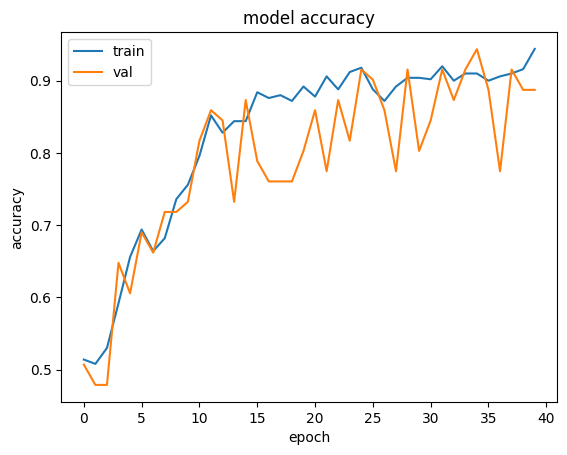

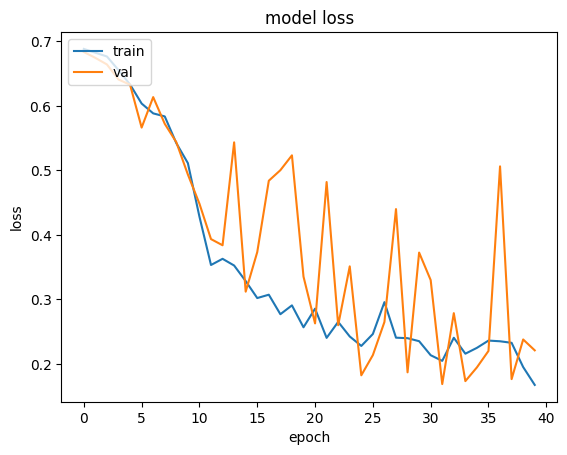

In [48]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
model.evaluate(test_generator)

5/5 [==============================] - 1s 221ms/step - loss: 0.2743 - accuracy: 0.8889


[0.27425479888916016, 0.8888888955116272]

In [99]:
y_true = test_generator.classes

In [100]:
y_pred = model.predict(test_generator)

5/5 [==============================] - 1s 197ms/step


In [101]:
def threshold_predictions(predictions, threshold=0.5):
  return [1 if i >= threshold else 0 for i in predictions]

In [102]:
y_pred = threshold_predictions(y_pred)

In [103]:
y_pred.count(0)

89

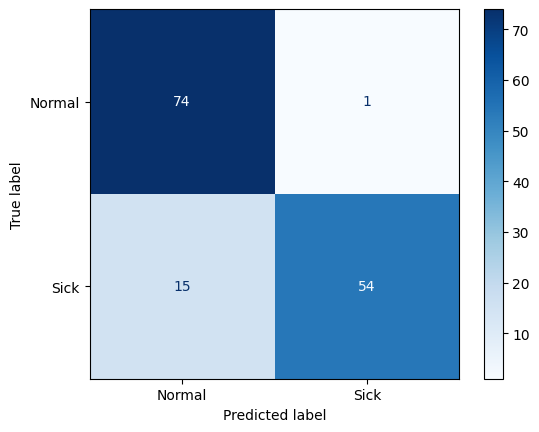

In [104]:
def plot_confusion_matrix(y_test, y_pred, labels):
  """
    y_test: true y labels
    y_pred: predicted y labels
    labels: class labels
  """
  disp = ConfusionMatrixDisplay.from_predictions(y_test,
                                                 y_pred,
                                                 display_labels=labels,
                                                 cmap="Blues")

plot_confusion_matrix( y_true, y_pred, ["Normal", "Sick"])

In [105]:
# classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90        75
           1       0.98      0.78      0.87        69

    accuracy                           0.89       144
   macro avg       0.91      0.88      0.89       144
weighted avg       0.90      0.89      0.89       144



# Test on unknown dataset

In [ ]:
# unzip dataset from google drive
!unzip /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/dataset2.zip

In [56]:
df2 = pd.read_csv("/content/drive/MyDrive/Personal/Computer Vision/dl_final_project/dataset2_image_classes.csv")

In [57]:
df2.head()

,patient,"diagnosis (0-Normal, 1-Sick)"
0,sick_eff0,0
1,sick_eff1,0
2,sick_eff2,0
3,sick_eff3,0
4,sick_eff4,0


In [58]:
df2.keys()

Index(['patient ', 'diagnosis (0-Normal, 1-Sick)'], dtype='object')

In [59]:
df2["patient "] = df2["patient "]+".png"
df2["diagnosis (0-Normal, 1-Sick)"] = df2["diagnosis (0-Normal, 1-Sick)"].astype(str)
df2.head()

,patient,"diagnosis (0-Normal, 1-Sick)"
0,sick_eff0.png,0
1,sick_eff1.png,0
2,sick_eff2.png,0
3,sick_eff3.png,0
4,sick_eff4.png,0


In [60]:
dataset2_generator = test_datagen.flow_from_dataframe(dataframe=df2,
                                                      directory="./images",
                                                      x_col="patient ",
                                                      y_col="diagnosis (0-Normal, 1-Sick)",
                                                      target_size=(391, 488),
                                                      class_mode="binary",
                                                      shuffle=False,
                                                      batch_size=32)

Found 224 validated image filenames belonging to 2 classes.


In [61]:
model.evaluate(dataset2_generator)

7/7 [==============================] - 2s 233ms/step - loss: 2.2117 - accuracy: 0.5134


[2.2117412090301514, 0.5133928656578064]

In [108]:
y_true2 = dataset2_generator.classes
y_pred2 = threshold_predictions(model.predict(dataset2_generator))

7/7 [==============================] - 2s 227ms/step


              precision    recall  f1-score   support

           0       0.54      0.19      0.28       112
           1       0.51      0.84      0.63       112

    accuracy                           0.51       224
   macro avg       0.52      0.51      0.46       224
weighted avg       0.52      0.51      0.46       224



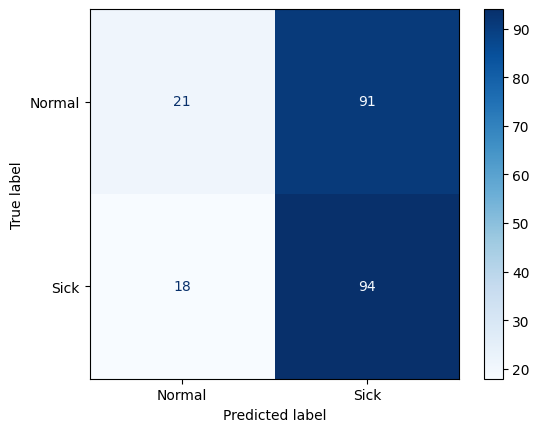

In [109]:
plot_confusion_matrix( y_true2, y_pred2, ["Normal", "Sick"])
print(classification_report(y_true2, y_pred2))

# Evaluate on unknown images

In [ ]:
!unzip /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/unknown_images.zip

In [ ]:
!ls ./unknow_data/unknown_images

10.png	15.png	1.png	24.png	29.png	33.png	38.png	42.png	47.png	5.png
11.png	16.png	20.png	25.png	2.png	34.png	39.png	43.png	48.png	6.png
12.png	17.png	21.png	26.png	30.png	35.png	3.png	44.png	49.png	7.png
13.png	18.png	22.png	27.png	31.png	36.png	40.png	45.png	4.png	8.png
14.png	19.png	23.png	28.png	32.png	37.png	41.png	46.png	50.png	9.png


In [81]:
# image reader
def read_image(path):
  img = load_img(path, target_size=INPUT_SIZE)
  img_reshaped = np.expand_dims(img, axis=0)
  return test_datagen.flow(img_reshaped, batch_size=1)[0]

In [106]:
unknown_images = os.listdir("./unknown_images")

In [89]:
read_image(os.path.join("./unknown_images", unknown_images[0]))
# predict classes for unknown images
image_names = []
image_predictions = []
for img_name in unknown_images:
  img = read_image(os.path.join("./unknown_images", img_name))
  prediction = threshold_predictions(model.predict(img)[0])[0]
  image_names.append(img_name) 
  image_predictions.append(prediction) 
  print(f"{img_name} - {prediction}")

1/1 [==============================] - 0s 47ms/step
20.png - 1
1/1 [==============================] - 0s 51ms/step
9.png - 0
1/1 [==============================] - 0s 42ms/step
35.png - 0
1/1 [==============================] - 0s 31ms/step
22.png - 1
1/1 [==============================] - 0s 31ms/step
10.png - 1
1/1 [==============================] - 0s 29ms/step
7.png - 0
1/1 [==============================] - 0s 55ms/step
29.png - 0
1/1 [==============================] - 0s 63ms/step
27.png - 0
1/1 [==============================] - 0s 29ms/step
4.png - 1
1/1 [==============================] - 0s 28ms/step
12.png - 1
1/1 [==============================] - 0s 29ms/step
46.png - 1
1/1 [==============================] - 0s 37ms/step
24.png - 0
1/1 [==============================] - 0s 21ms/step
47.png - 0
1/1 [==============================] - 0s 18ms/step
40.png - 0
1/1 [==============================] - 0s 20ms/step
39.png - 0
1/1 [==============================] - 0s 20ms/step
17.png

In [90]:
image_predictions.count(0)

30

In [91]:
image_predictions.count(1)

20

In [96]:
image_prediction_classes=["normal" if i == 0 else "sick" for i in image_predictions]

In [97]:
unknown_preds_df = pd.DataFrame({"image":image_names,
                                 "diagnosis": image_prediction_classes })

In [98]:
unknown_preds_df.head()

,image,diagnosis
0,20.png,sick
1,9.png,normal
2,35.png,normal
3,22.png,sick
4,10.png,sick


In [107]:
# export predictions
unknown_preds_df.to_csv("nb2-unknown-preds.csv")